# Fitting XMM-Newton data with the APEC model #

The Astrophysical Plasma Emission Code (APEC, [Smith et al. 2001](https://ui.adsabs.harvard.edu/abs/2001ApJ...556L..91S/abstract)) is a state-of-the-art code to model the X-ray emission of optically thin astrophysical plasma in collisional equilibrium. APEC has been widely used in the literature to study the spectra of a wide variety of sources, such as galaxy clusters and groups, supernova remnants, or stellar coronae. The code self-consistently models the continuum (bremsstrahlung) emission as well as the pseudo-continuum and over 10,000 individual emission lines.

Astromodels includes a native Python implementation of APEC based on [``pyatomdb``](https://atomdb.readthedocs.io/en/master/). As the model is only available when an installation of ``pyatomdb`` can be found, the user must make sure ``pyatomdb`` is installed and the required atomic data files have been downloaded.

## Setting up pyatomdb ##

``pyatomdb`` is easily installable using pip:

    $] pip install pyatomdb
    
When running the code for the first time, the user will be requested to download the ATOMDB database locally

    $] python -c "import pyatomdb"
    
This command will prompt the user to choose a directory to store the atomic data (usually ``$HOME/atomdb``). Once the data have been downloaded, the ATOMDB environment variable must be set to indicate the location of the atomic data

    $] export ATOMDB=$HOME/atomdb

OK, we're all set!

## Loading the APEC model ##

Once ``pyatomdb`` is properly installed, it is available as a "Function1D" object


In [1]:
%%capture

from threeML import * 

modapec = APEC()

The intensity of the various lines in the model is set relative to the Solar abundance. Therefore, one must set the Solar abundance table to predict the line intensity, using the ``init_session`` method of the APEC class. By default, i.e. if the ``init_session`` method is ran with no argument, the code defaults to [Anders & Grevesse (1989)](https://ui.adsabs.harvard.edu/abs/1989GeCoA..53..197A/abstract). 

In [2]:
modapec.init_session(abund_table='AG89')

Will not thermally broaden lines


If, for instance, we wish to initialize the APEC model to use the [Lodders & Palme (2009)](https://www.lpi.usra.edu/meetings/metsoc2009/pdf/5154.pdf) table, we pass

    modapec.init_session(abund_table='Lodd09')

In [3]:
modapec.display()

* description: The Astrophysical Plasma Emission Code (APEC, Smith et al. 2001) contributed
    * by Dominique Eckert
  * formula: $n.a.$
  * parameters:
    * K:
      * value: 1.0
      * desc: Normalization in units of 1e-14/(4*pi*(1+z)^2*dA*2)*EM
      * min_value: 1.0e-30
      * max_value: 1000.0
      * unit: ''
      * is_normalization: true
      * delta: 0.1
      * free: true
    * kT:
      * value: 1.0
      * desc: Plasma temperature
      * min_value: 0.08
      * max_value: 64.0
      * unit: ''
      * is_normalization: false
      * delta: 0.1
      * free: true
    * abund:
      * value: 1.0
      * desc: Metal abundance
      * min_value: 0.0
      * max_value: 5.0
      * unit: ''
      * is_normalization: false
      * delta: 0.01
      * free: false
    * redshift:
      * value: 0.1
      * desc: Source redshift
      * min_value: 0.0
      * max_value: 10.0
      * unit: ''
      * is_normalization: false
      * delta: 0.001
      * free: false

The parameters of the model are set in the following way

In [4]:
modapec.kT.value = 3.0 # 3 keV temperature

modapec.K.value = 1e-3 # Normalization, proportional to emission measure

modapec.redshift.value = 0. # Source redshift

modapec.abund.value = 0.3 # The metal abundance of each element is set to 0.3 times the Solar abundance

Now let's see how the model depends on the input temperature...

In [5]:
import numpy as np

energies = np.logspace(-1., 1.5, 1000) # Set up the energy grid

ktgrid = [0.2,0.5,1.0,2.0,3.0,5.0,7.0,9.0,12.0,15.0] # Temperature grid


<Figure size 432x288 with 0 Axes>

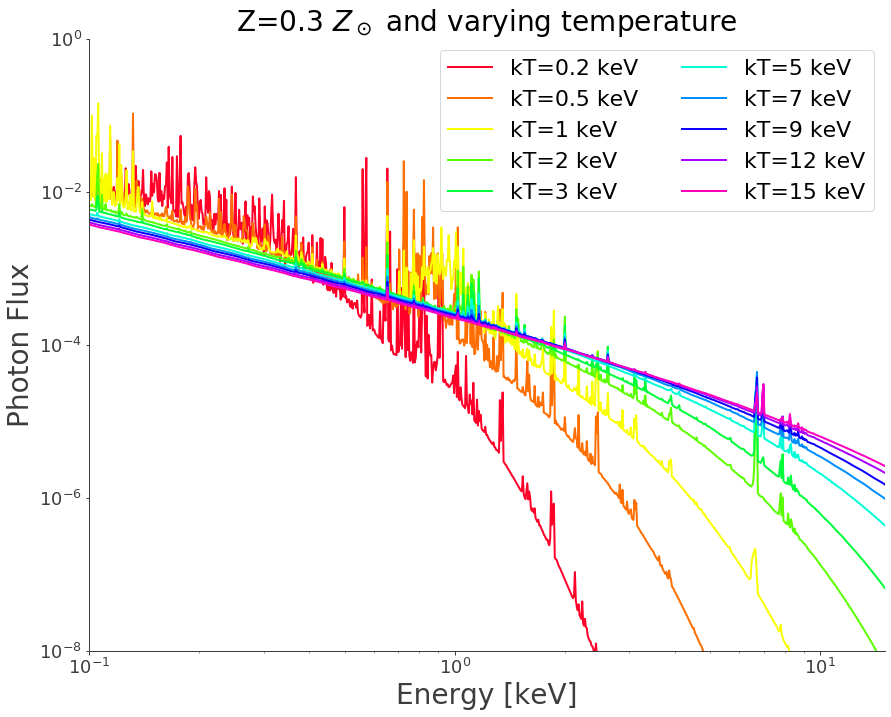

In [6]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx

%matplotlib inline

plt.clf()
fig=plt.figure(figsize=(13,10))
ax = fig.add_axes([0.12, 0.12, 0.85, 0.85])
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(18)

nspec = len(ktgrid)

values = range(nspec)
cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=values[-1])
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
ccc=[]
for i in range(nspec):
    ccc.append(scalarMap.to_rgba(i))


for i in range(nspec):
    modapec.kT.value = ktgrid[i]
    plt.plot(energies,modapec(energies),color=ccc[i],label='kT=%g keV'%(ktgrid[i]))

plt.xscale('log')
plt.yscale('log')

plt.xlabel('Energy [keV]',fontsize=28)
plt.ylabel('Photon Flux',fontsize=28)
plt.axis([0.1,15.,1e-8,1.0])
plt.title('Z=0.3 $Z_\odot$ and varying temperature',fontsize=28)
plt.legend(fontsize=22, ncol=2)


Now let's see how the model depends on metallicity for a temperature of 1 keV...

In [7]:
Zgrid = [0., 0.1, 0.3, 0.5, 1., 2.] # Metallicities wrt Solar

modapec.kT.value = 1.0

<Figure size 432x288 with 0 Axes>

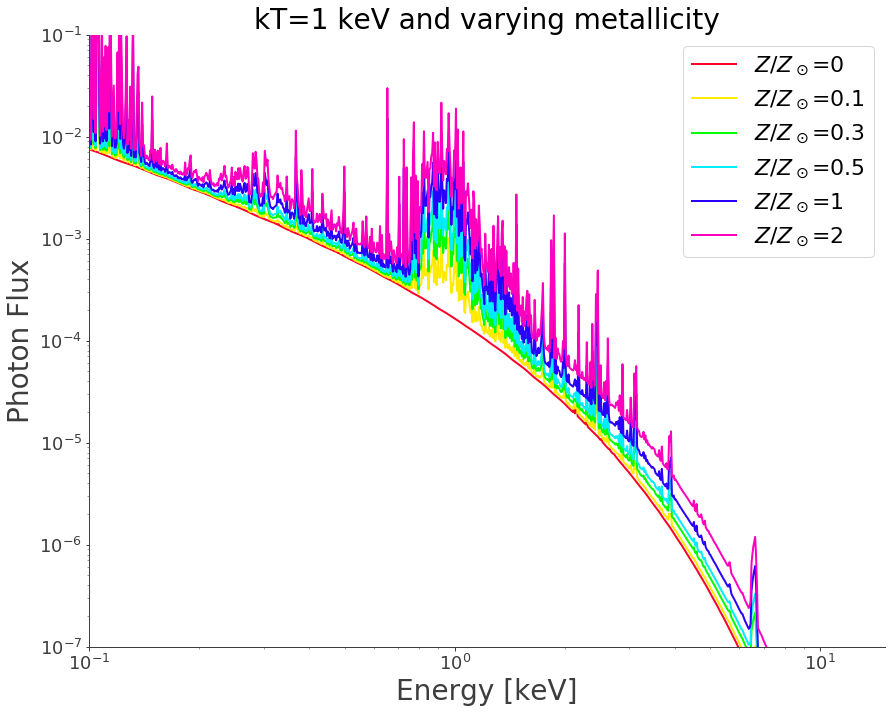

In [8]:
plt.clf()
fig=plt.figure(figsize=(13,10))
ax = fig.add_axes([0.12, 0.12, 0.85, 0.85])
for item in (ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(18)

nspec = len(Zgrid)

values = range(nspec)
cm = plt.get_cmap('gist_rainbow')
cNorm  = colors.Normalize(vmin=0, vmax=values[-1])
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=cm)
ccc=[]
for i in range(nspec):
    ccc.append(scalarMap.to_rgba(i))


for i in range(nspec):
    modapec.abund.value = Zgrid[i]
    plt.plot(energies,modapec(energies),color=ccc[i],label='$Z/Z_\odot$=%g'%(Zgrid[i]))

plt.xscale('log')
plt.yscale('log')

plt.xlabel('Energy [keV]',fontsize=28)
plt.ylabel('Photon Flux',fontsize=28)
plt.axis([0.1,15.,1e-7,0.1])
plt.title('kT=1 keV and varying metallicity',fontsize=28)
plt.legend(fontsize=22)


## Comparison with XSPEC ##

To test the implementation, let's simulate a spectrum with XSPEC and fit it within 3ML using the APEC model. We simulate an _XMM-Newton_/EPIC-pn spectrum with a temperature of 5 keV, a metallicity of 0.3 Solar, a normalization of unity and a redshift of 0.1. The simulated model is absorbed by photo-electric absorption (PhAbs model) with a column density of $10^{21}$ cm$^{-2}$. We start by declaring the model,

In [9]:
phabs = PhAbs()

phabs.NH.value = 0.1 # A value of 1 corresponds to 1e22 cm-2

phabs.NH.fix = True # NH is fixed

phabs.init_xsect(abund_table='AG89')

modapec.kT = 3.0 # Initial values

modapec.K = 0.1

modapec.redshift = 0.1

modapec.abund = 0.3

mod_comb = phabs * modapec

Now we load the simulated spectrum in 3ML...

In [10]:
xmm_pha = get_path_of_data_file("datasets/xmm/pnS004-A2443_reg2.fak")
xmm_rmf = get_path_of_data_file("datasets/xmm/pnS004-A2443_reg2.rmf")
xmm_arf = get_path_of_data_file("datasets/xmm/pnS004-A2443_reg2.arf")

ogip = OGIPLike("ogip", observation=xmm_pha, response=xmm_rmf, arf_file=xmm_arf)

pts = PointSource('mysource',0,0,spectral_shape=mod_comb)


Let's have a look at the loaded spectrum...

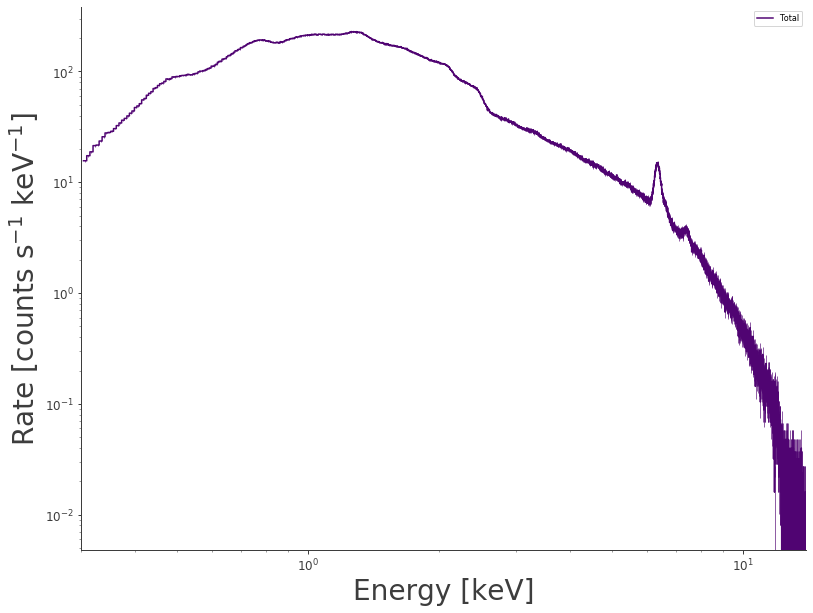

In [11]:
fig = ogip.view_count_spectrum()

fig.set_size_inches(13,10)

ax = fig.get_axes()[0]

ax.set_xlim(left=0.3,right=14.)
ax.set_xlabel('Energy [keV]',fontsize=28)
ax.set_ylabel('Rate [counts s$^{-1}$ keV$^{-1}$]',fontsize=28)



Here we set up the likelihood and fit the data

In [12]:
ogip.remove_rebinning()

ogip.set_active_measurements('0.5-10.')

ogip.rebin_on_source(20)

model = Model(pts)

jl = JointLikelihood(model,DataList(ogip))

result = jl.fit()


Best fit values:



,result,unit
parameter,,
mysource.spectrum.main.composite.K_2,(9.8742 +/- 0.0033) x 10^-1,1 / (cm2 keV s)
mysource.spectrum.main.composite.kT_2,5.019 +/- 0.005,keV



Correlation matrix:



1.00,-0.30
-0.30,1.00



Values of -log(likelihood) at the minimum:



,-log(likelihood)
ogip,9682.695868
total,9682.695868



Values of statistical measures:



,statistical measures
AIC,19369.398043
BIC,19380.497261


The fitted values are within 1% of the input ones from XSPEC, showing that the native 3ML implementation is accurate. We can visualize the fit in the following way

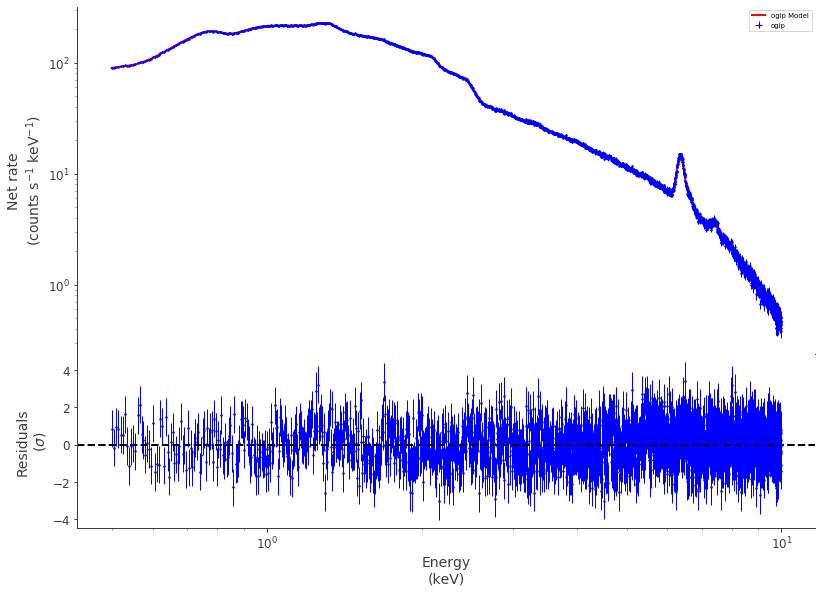

In [13]:
fig = display_spectrum_model_counts(jl,data_color='blue',model_color='red', min_rate=5e-4)

fig.set_size_inches(13,10)
